# Identifying Fraud from Enron Email

This is a report on the process of builing estimators for Fraud Detection using machine learning.

A more compact and summurized report can be found as 
<a href='https://raw.githubusercontent.com/yyforyongyu/nanodegree-machine-learning/master/final_project/documentation.html' target='_blank'>Documentation (html)</a>, or 
<a href='https://github.com/yyforyongyu/nanodegree-machine-learning/blob/master/final_project/documentation.ipynb' target='_blank'> Documentation (ipynb) </a>.

## Overview
In this report, there are series of investigations performed to make a robust, strong final estimator to predict a person-of-interest(poi). These include,
- an overview of the dataset.
- outlier cleaning.
- a performance comparison between two datasets, outlier-cleaned and outlier-non-cleaned.
- a performance comparison between scaled features and non-scaled features.
- creating three features, "stock_salary_ratio", "poi_from_ratio", "poi_to_ratio", and evaluating them.
- a performance comparison among different feature selection methods, including SelectKBest, LinearSVC, RandomizedLogisticRegression, and ExtraTreesClassifier.
- a performance comparison between including PCA and excluding PCA.
- a performance comparison among different classifiers, including LinearSVC, KNeighborsClassifier, and AdaBoostClassifer.
- tuning algorithms using F1 score as evaluation metric.
- cross-validation on the final estimator.

Several helper functions are built for this project in poi_helper.py. Since this report only focuses on methodology in machine learning, we will only introduce them briefly here. For more details, report 
<a href='https://raw.githubusercontent.com/yyforyongyu/nanodegree-machine-learning/master/final_project/poi_id.html' target='_blank'>poi_id.html</a>
has all the thoughts and steps in building these functions.

## Methodology
When finding a best combination out of groups of factors, there are usually two ways to think about it. One way would be simply find the best solution from each group, then chain all the solutions together to make the final combination. The assumption is that the best of each independent thing can be grouped to be the best of a new thing. In reality, this is rarely true since the best from one group might have a negtive effect on the best from another group. If we are to apply this method into the analysis, in short, we would need to first, find the best feature selection method, then find the best calssifier, lastly combine the feature selection and classifier to make the final estimator. However, from the report 
<a href='https://raw.githubusercontent.com/yyforyongyu/nanodegree-machine-learning/master/final_project/poi_id.html' target='_blank'>poi_id.html</a>,
using a SelectKBest + LinearSVC could have an accuracy score of 0.94, same when using RandomizedLogisticRegression + KNeighbors, although the runtimes were different. However, when applying RandomizedLogisticRegression + LinearSVC, or SelectKBest + KNeighbors, accuracy scores became lower. This clearly indicates that, for each classifier algorithm, there is a best fit feature selection method. Simply chaining a best classifier and a feature selection seperately won't produce the best result. It becomes rather clear when all the algorithms were applied on both outlier-cleaned and full datasets. The best estimator for one dataset won't work on a different dataset.

So machine learning is really about finding a specific, nearly unique solution to a question, which brings me to think about the second way, exhaustively trying out combinations of all factors, rather than finding a best answer by groups. This assumes that a simple change in one unit can make a total difference. Unfortunately, this method also creates a problem, large time consumptions.

For this analysis, there are two datasets to be tested, with or without PCA, feature scaling, with four feature selection method, and three classifiers, considering only 15 parameters to be tuned on each classifier, 5 parameters to be tuned on each feature selection, and 10 parameters to be tuned on cross validation, the number of combinations is,
$$2*2*2*4*5*3*15*10 = 72000$$
And it is not likely we will conduct all the possibilies here at once, we will have to make a tradeoff.

For this analysis, the parameters of four feature selection methods won't be tuned untill one best feature selection method is found, then the cross validation will be tuned, which brings the possible combination down to 1440 before we start to tune on feature selection and cross validation. From my experience, this is acceptable as the dataset is small.

# Summary of Dataset
A summary of findings,
- there are 146 data points with 21 features, and a total of 3066 obervations.
- there are 18 people who is an point of interest.
- 1,358 data points are missing.
- the top 3 features with most missing values are "loan_advances", "director_fees", and "restricted_stock_deferred".

In [1]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from poi_helper import *
import numpy as np

### Load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

In [2]:
# number of data points
len(data_dict.keys())

146

In [3]:
# number of features available
len(data_dict['METTS MARK'])

21

In [4]:
# available features
data_dict["METTS MARK"].keys()

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

In [5]:
# people of interest
count = 0
for key, item in data_dict.iteritems():
    if item["poi"]:
        print key
        count += 1
count

HANNON KEVIN P
COLWELL WESLEY
RIEKER PAULA H
KOPPER MICHAEL J
SHELBY REX
DELAINEY DAVID W
LAY KENNETH L
BOWEN JR RAYMOND M
BELDEN TIMOTHY N
FASTOW ANDREW S
CALGER CHRISTOPHER F
RICE KENNETH D
SKILLING JEFFREY K
YEAGER F SCOTT
HIRKO JOSEPH
KOENIG MARK E
CAUSEY RICHARD A
GLISAN JR BEN F


18

In [6]:
# create a dictionary for all missing values
missing = {}
for key, item in data_dict.iteritems():
    for elem, value in item.iteritems():
        if value == "NaN":
            if elem not in missing:
                missing[elem] = 1
            else:
                missing[elem] += 1

In [7]:
# number of missing values
number_of_missing = 0
for key, item in missing.iteritems():
    number_of_missing += item
number_of_missing

1358

In [8]:
missing

{'bonus': 64,
 'deferral_payments': 107,
 'deferred_income': 97,
 'director_fees': 129,
 'email_address': 35,
 'exercised_stock_options': 44,
 'expenses': 51,
 'from_messages': 60,
 'from_poi_to_this_person': 60,
 'from_this_person_to_poi': 60,
 'loan_advances': 142,
 'long_term_incentive': 80,
 'other': 53,
 'restricted_stock': 36,
 'restricted_stock_deferred': 128,
 'salary': 51,
 'shared_receipt_with_poi': 60,
 'to_messages': 60,
 'total_payments': 21,
 'total_stock_value': 20}

# Outlier Investigation

As we already known in mini projects, there is an outlier named "TOTAL" in this dataset. We will need to remove it before any further analysis.

In [9]:
# remove the outlier 'TOTAL'
data_dict.pop("TOTAL")

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

## Plots of the Outliers

To understand the outliers in this dataset, plots are created by using salary against every other feature but poi, which is used to color data points in each plot. As a starting point, all the available features will be selected and put into the model. Later in this report, some features will be removed based on their feature selection score.

In [10]:
import pandas as pd

# create features for plots
# features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".
features_list = ['poi',
                 'salary',
                 'to_messages',
                 'deferral_payments',
                 'total_payments',
                 'exercised_stock_options',
                 'bonus',
                 'restricted_stock',
                 'shared_receipt_with_poi',
                 'restricted_stock_deferred',
                 'total_stock_value',
                 'expenses',
                 'loan_advances',
                 'from_messages',
                 'other',
                 'from_this_person_to_poi',
                 'director_fees',
                 'deferred_income',
                 'long_term_incentive',
                 'from_poi_to_this_person']

# format the dataset
data = featureFormat(data_dict, features_list)

# create a pandas dataframe
df = pd.DataFrame(data, columns = features_list)

In the following plots, blue color stands for poi, red color stands for non-poi.

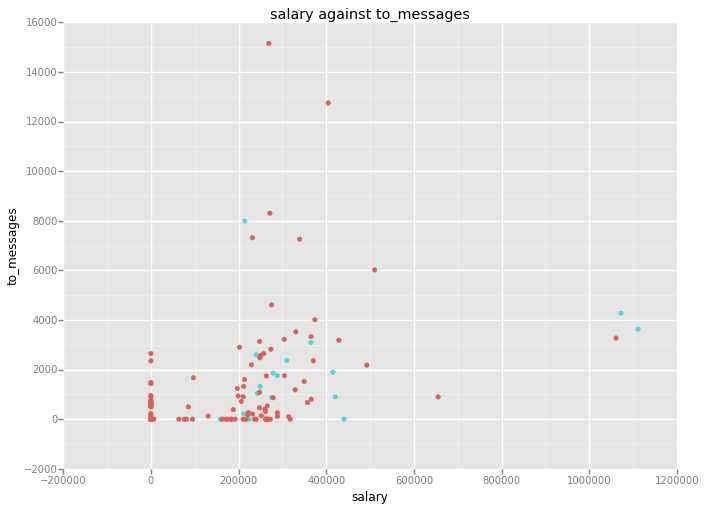

<ggplot: (281949797)>


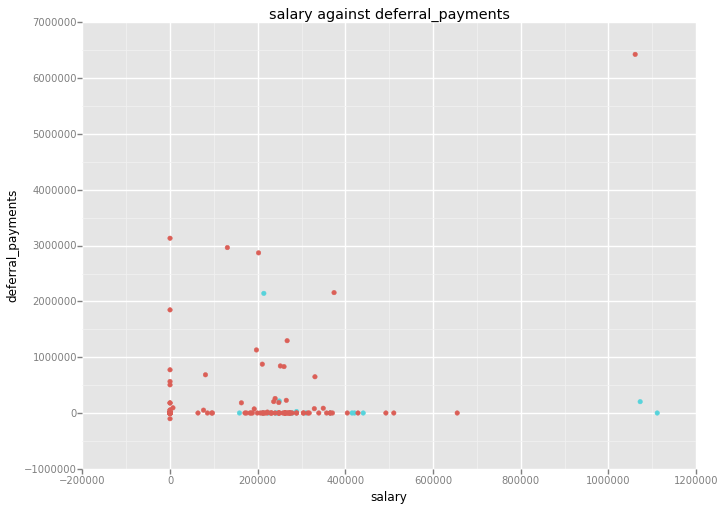

<ggplot: (281949829)>


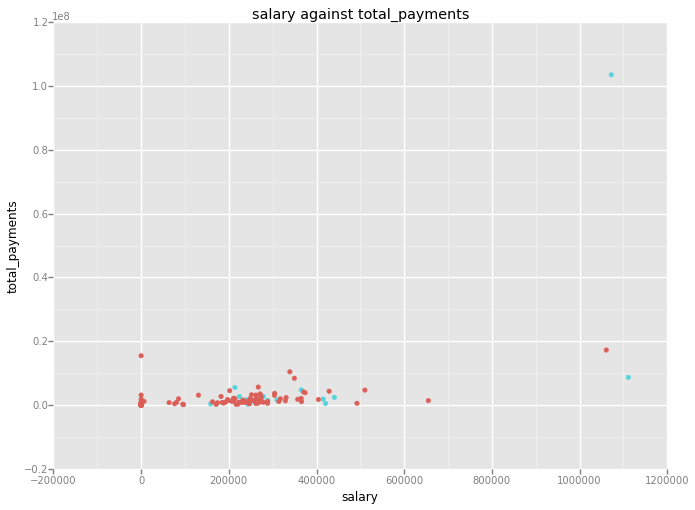

<ggplot: (280296701)>


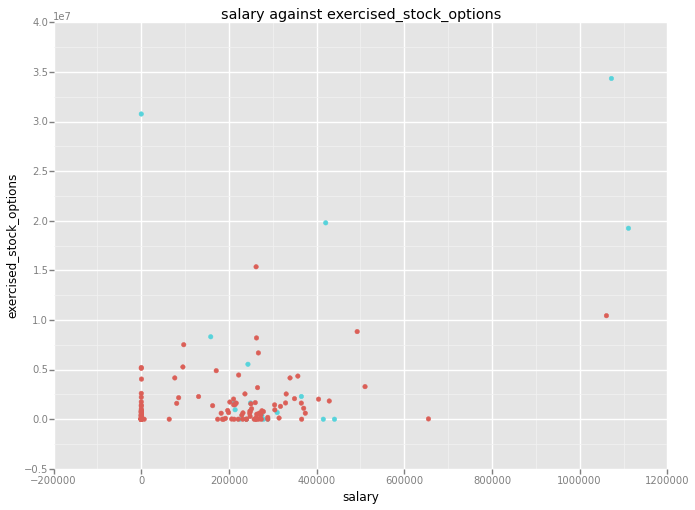

<ggplot: (270695161)>


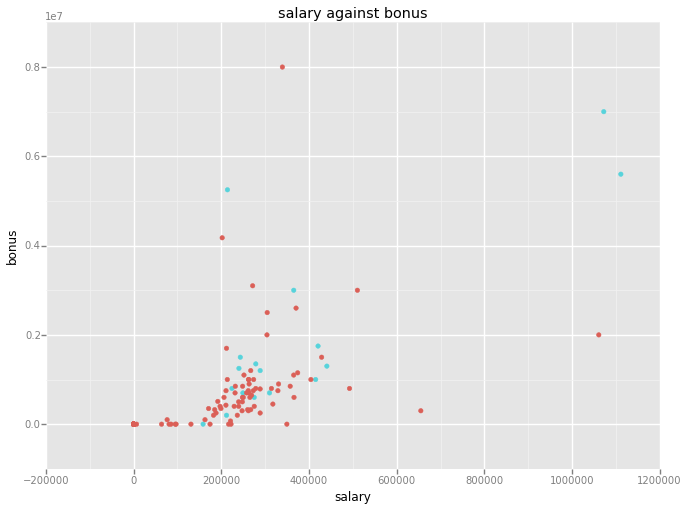

<ggplot: (280130225)>


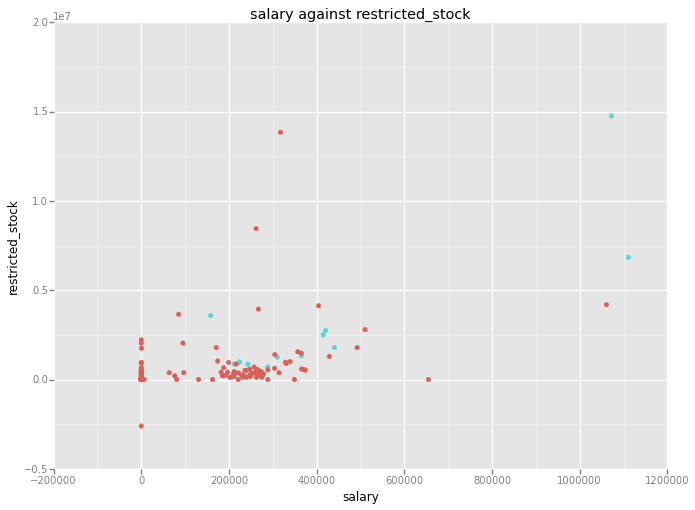

<ggplot: (279203165)>


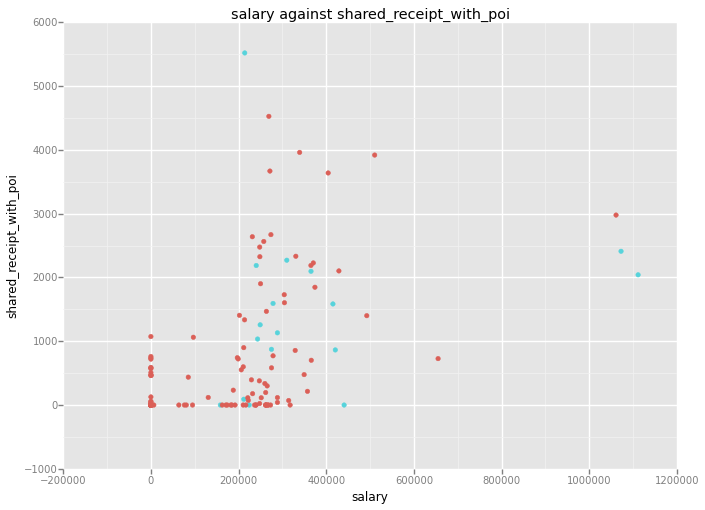

<ggplot: (279616305)>


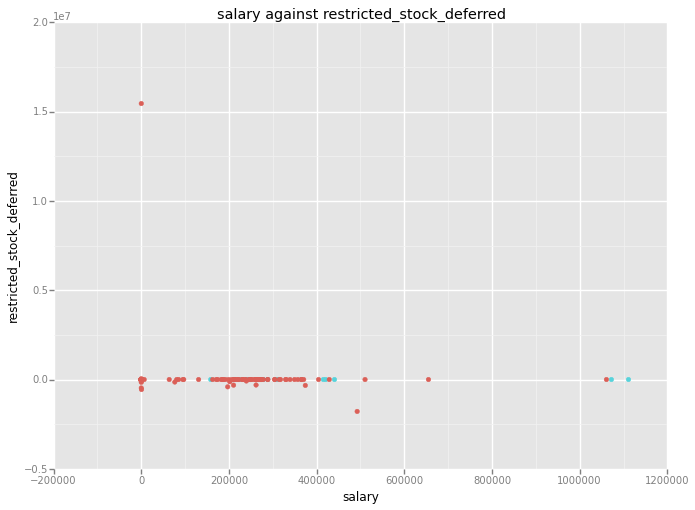

<ggplot: (279986105)>


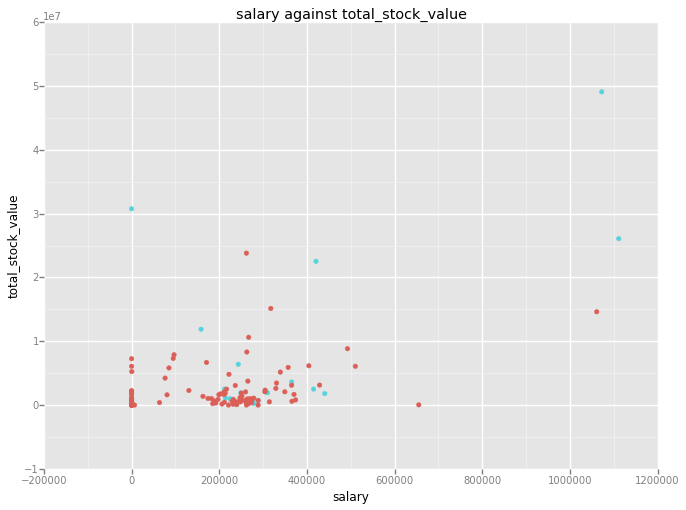

<ggplot: (279967081)>


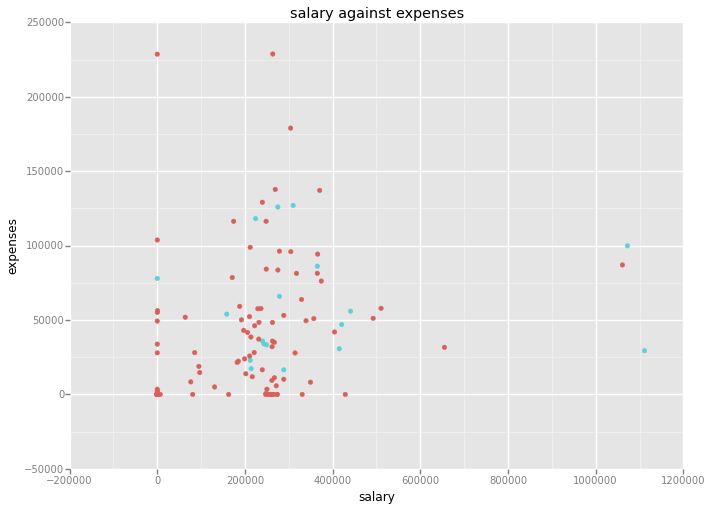

<ggplot: (280239513)>


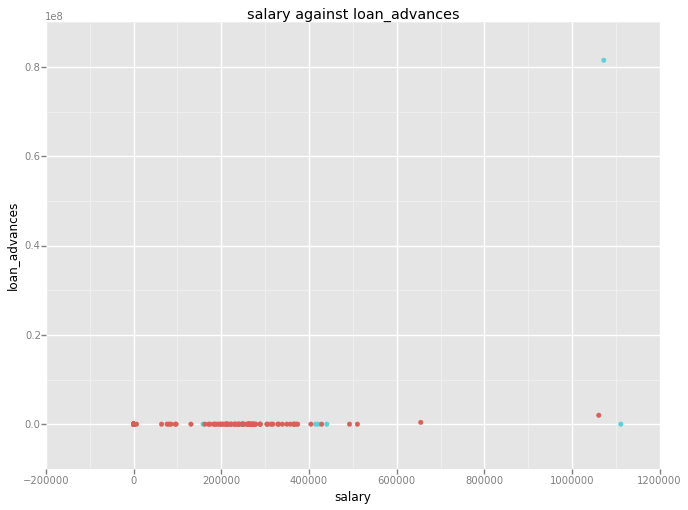

<ggplot: (281312541)>


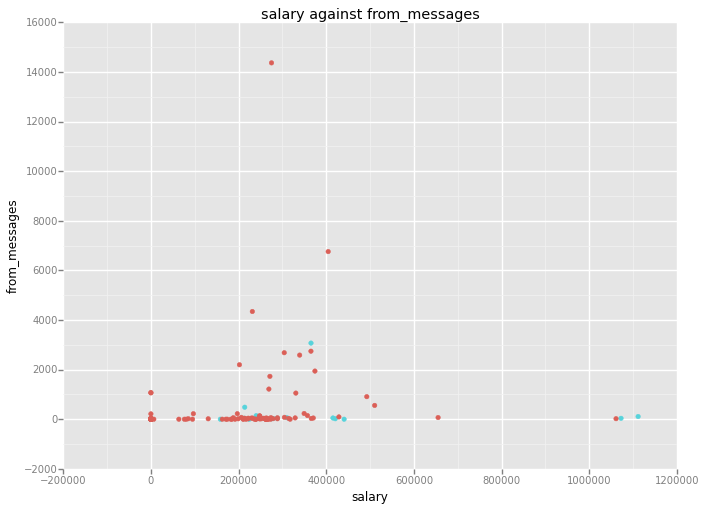

<ggplot: (281322641)>


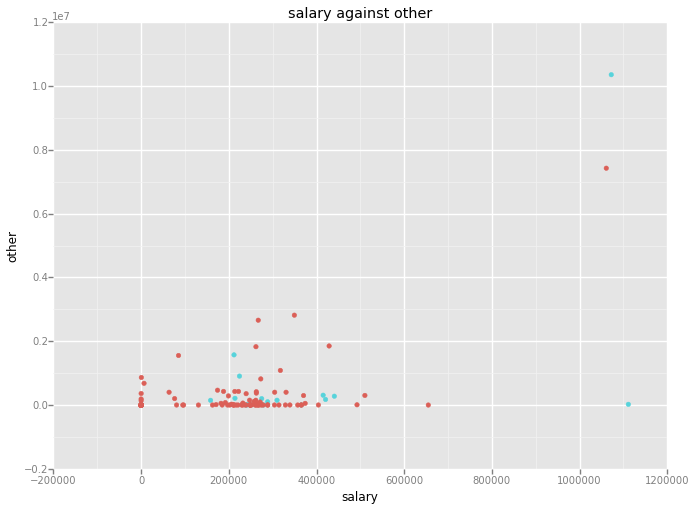

<ggplot: (279772293)>


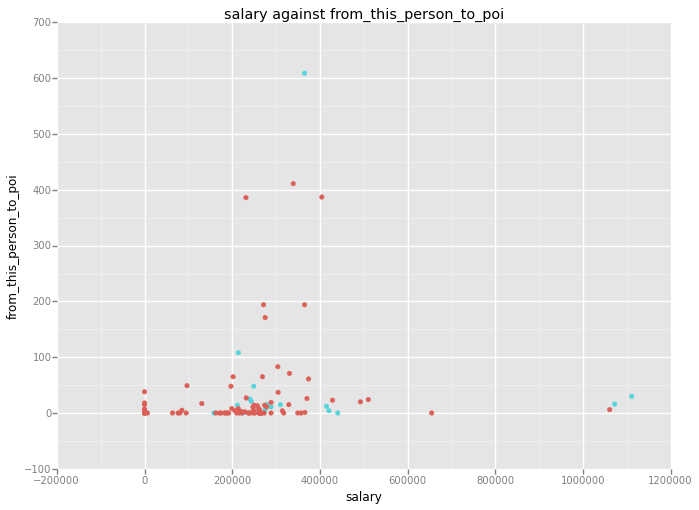

<ggplot: (279772225)>


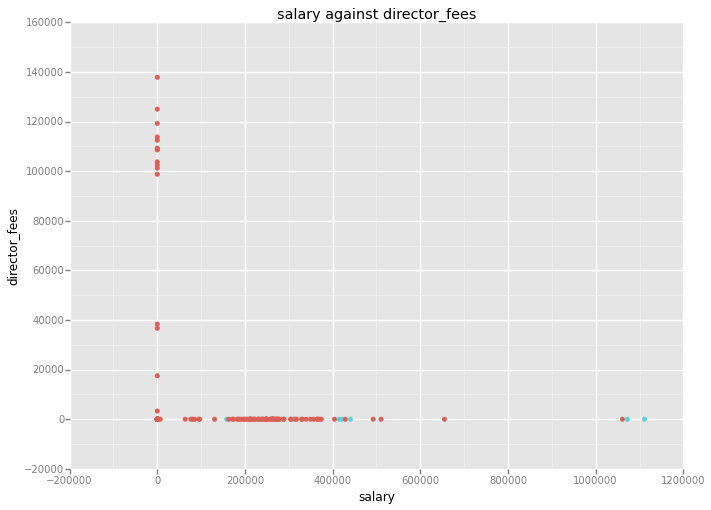

<ggplot: (279899153)>


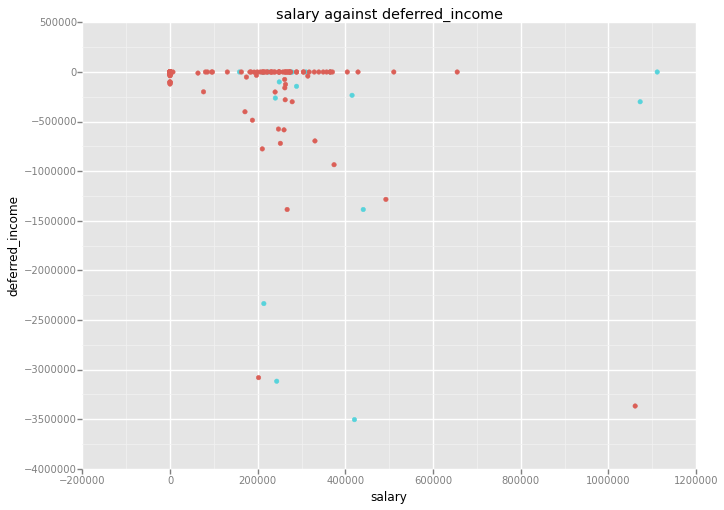

<ggplot: (280025141)>


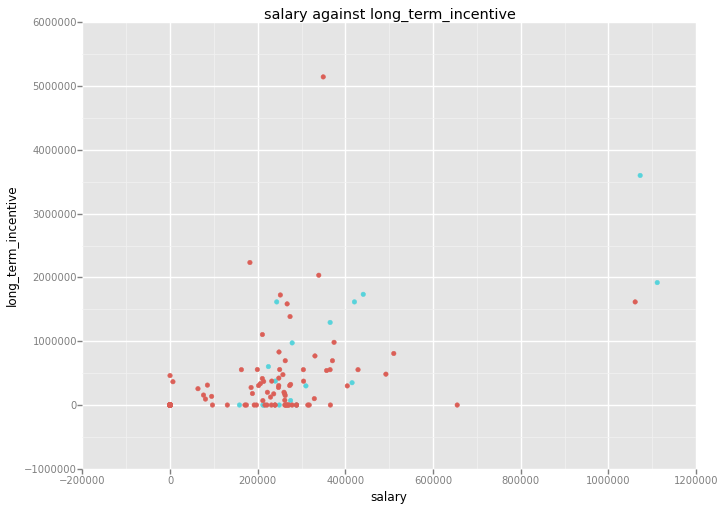

<ggplot: (280148273)>


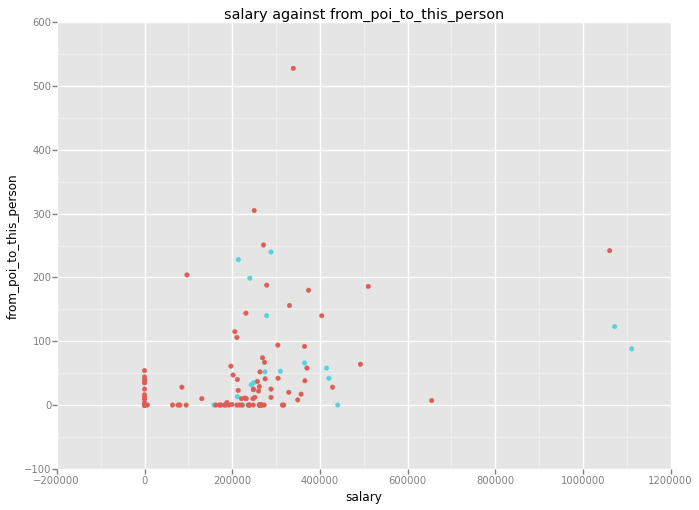

<ggplot: (280148273)>


In [11]:
%matplotlib inline
from ggplot import *

# iter through all features
# x axis will always be salary
# poi is represented by colors of points
# the rest of features are put in y axis
for feature in features_list:
    if feature != "poi" and feature != "salary":
        print ggplot(aes(x = 'salary', y = feature, color = 'poi'),
               data = df) +\
        geom_point() +\
        ggtitle("salary against " + feature)

## Outlier Removal

The purpose of removing outliers is to prevent the model being misrepresented by extreme cases, which comes with an assumption that either the extreme cases rarely happen, or they don't carry engough valuable infomration to be kept in the model. This can be true for some of the features, but could be controversy for "total_payment" feature, and shouldn't be applied to "exercised_stock_options" as the top four outliers are all person of interest. On the other hand, if we are to treat top 10% of each feature as outliers, it is not hard to imagine that the final dataset will have much less than 90%. A large deduction in the original dataset will cause the model becoming weaker.

Given all these thoughts, we will start the cleaning experiment using a simple method. By fitting in a linear regression model, we will calculate the variance between the predicted values and true values, then treat features whoes predictions have top 10% variance as outliers. Based on that, we can then decide what to do with the outliers.


In [12]:
### check on the score before outlier cleaning
features, labels = featureLabelSplit(data_dict, features_list)
buildRegression(features, labels)[1]

0.356004646266603

In [13]:
### clean the outliers
### extract normal data points and outliers
cleaned_data, outliers = outlierCleaner(features, labels)

In [14]:
### extract labels and features from cleaned_data
cleaned_labels, cleaned_features = targetFeatureSplit(cleaned_data)

# fit the model again and check the score
buildRegression(cleaned_features, cleaned_labels)[1]

0.82103305215836875

A removal of the outliers improved the score of the linear model dramastically from 0.35 to 0.82. Although it's good to see improvement in score, it's always necessary to take a look at the removed outliers.

## Check on Outliers

In [15]:
### change the data format from numpy array to python dictionary
outliers_dataset = personMapping(featureReformat(outliers, features_list), data_dict, features_list)

In [16]:
### number of outliers
len(outliers_dataset)

14

In [17]:
### name of outliers who is not a poi
for key, item in outliers_dataset.iteritems():
    if item['poi'] == 0.0:
        print key

LAVORATO JOHN J


## Strategy on Outlier Removal

As mentioned above, simply removing the outliers might cause an issue for later on analysis. While the imporvement in score of the linear model is surely tempting, do note that, this is not the model that we will use to conduct machine learning in this dataset. 

On the other hand, there's no surprising that most of the person of interest(13 out 18) are flagged as outliers given the background knowledge of Enron Fraud. In this case, the outliers are the targets we want to find, according to <a href='https://discussions.udacity.com/t/outlier-removal/7446' target='_blank'>this post in discussion forum</a>, we can manually decided to include or exclude the outliers or not in the training set. This strategy will be applied when processing the dataset.

Given the though above, when fitting in datasets later, there are two datasets used to find out whether outlier removal is a better chocie,
- the original, full dataset.
- the outlier-cleaned dataset, with cleaning only on training set.

# Preprocessing Features

## Feature Creation
To dig out more patterns from the dataset, three new features, "stock_salary_ratio", "poi_from_ratio", "poi_to_ratio", are created as following.

- stock_salary_ratio: stock_salary_ratio takes the result from total_stock_value divided by salary. This feature is useful based on the assumption that a person of interest usually has a unusual large stock value since it's under the table, while salary information could be more easily known by public, thus the ratio could give information to identify the poi. The bigger the ratio, the more likely it is a poi.
- poi_from_ratio: poi_from_ratio takes result from from_poi_to_this_person divided by from_messages. This feature assumes that if a person is a poi, he/she tends to have more contacts with another poi, therefore the ratio would be bigger. And same applie to feature poi_to_ratio.

In [18]:
### add new features to dataset
for key, item in data_dict.iteritems():
    ### add stock_salary_ratio
    if item['salary'] != "NaN" and item['total_stock_value'] != "NaN":
        item['stock_salary_ratio'] = float(item['total_stock_value']) / item['salary']
    else:
        item['stock_salary_ratio'] = "NaN"
    
    ### add poi_from_ratio
    if item['from_messages'] != "NaN" and item['from_poi_to_this_person'] != "NaN":
        item['poi_from_ratio'] = float(item['from_poi_to_this_person']) / item['from_messages']
    else:
        item['poi_from_ratio'] = "NaN"
        
    ### add poi_to_ratio
    if item["to_messages"] != "NaN" and item["from_this_person_to_poi"] != "NaN":
        item["poi_to_ratio"] = float(item["from_this_person_to_poi"]) / item["to_messages"]
    else:
        item["poi_to_ratio"] = "NaN"

In [19]:
new_features_list = features_list + ["stock_salary_ratio", "poi_from_ratio", "poi_to_ratio"]

## Feature Scaling

Depending on the algorithms chosen, feature scaling may be necessary. We will perform feature scaling anyway in case it is needed for later algorithms.

This process is built into trainModel function, using sklearn.preprocessing.scale( ) as a standardization method.

## Feature Selection

To get a comprehensive processing before any fitting into models, a variety of feature selection methods for classification listed in 
<a href='http://scikit-learn.org/stable/modules/feature_selection.html' target='_blank'>sklearn documentations</a> 
are explored, including SelectKBest, LinearSVC, RandomizedLogisticRegression, and ExtraTreesClassifier.

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.svm import LinearSVC
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

feature_selection = [('k_best', SelectKBest(k = 5)),
                     ('linear_svc_l1', LinearSVC(C=0.01, penalty="l1", dual=False, random_state=31)),
                     ('logistic_reg', RandomizedLogisticRegression(C=1, selection_threshold=0.01, random_state=31)),
                     ('extra_tree', ExtraTreesClassifier(max_features=5, random_state=31))]

## PCA
PCA is imported to conduct dimensions deduction. Depending on the performances, the decision to include PCA or not will be made later.

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)

When calling PCA, the features are scaled before further processing.

## Feature Union
Feature Union function in sklearn could be handy when we want to combine PCA process with other feature selection method. 
<a href='http://scikit-learn.org/stable/auto_examples/feature_stacker.html' target='_blank'>One example from sklearn</a>
showing the usage of feature union. Do note that, a feature union is not a combination of features but rather a chain of two different processes.

In [22]:
from sklearn.pipeline import FeatureUnion

### chain pca to feature selection
combined_feature = []
for method in feature_selection:
    new_method = FeatureUnion([('pca', PCA(n_components=5)), method])
    name = method[0] + "_with_pca"
    combined_feature.append((name, new_method))

In [23]:
### update feature selection list
feature_selection += combined_feature

# Pick and Prepare Classifiers

According to 
<a href='http://scikit-learn.org/stable/tutorial/machine_learning_map/' target='_blank'>this cheat sheet in sklearn</a>, 
there are at least four classification methods can be used,
- LinearSVC
- KNeighbors Classifier
- SVC
- Ensemble Classifers

In this report, we will check on LinearSVC, KNeighborsClassifier, and AdaBoostClassifier.

In [24]:
linear_svc = LinearSVC(random_state=31, dual=False)

params_svc = {'linear_svc__C':[1e-2, 1e-1, 1, 1e2, 1e3],
              'linear_svc__penalty': ["l1", "l2"],
              'linear_svc__tol': [1e4, 1e3, 1e2, 1],
              'linear_svc__max_iter': [1e2, 1e3, 1e4, 1e5]}

In [25]:
from sklearn.neighbors import KNeighborsClassifier

k_neighbors = KNeighborsClassifier()

params_kneighbors = {'k_neighbors__n_neighbors': [1, 5, 10, 20, 50],
                     'k_neighbors__weights': ["uniform", "distance"],
                     'k_neighbors__algorithm':["ball_tree", "kd_tree", "brute"],
                     'k_neighbors__leaf_size': [2, 5, 10, 30, 50, 100],
                     'k_neighbors__p': [1,2]}

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_boost = AdaBoostClassifier(random_state=31)

params_adaboost = {'ada_boost__base_estimator': [DecisionTreeClassifier(), None],
                   'ada_boost__n_estimators': [1, 5, 10, 20, 50, 100],
                   'ada_boost__algorithm': ['SAMME', 'SAMME.R'],
                   'ada_boost__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10],
                   }

In [27]:
### put all classifiers together
classifiers = [('linear_svc', linear_svc, params_svc),
               ('k_neighbors', k_neighbors, params_kneighbors),
               ('ada_boost', ada_boost, params_adaboost)]

# Validation and Evaluation


## Validation
To prevent overfitting, a cross validation is needed to split the dataset into training and testing. We will use train_test_split method with a default test_size of 0.25 for finding the best estimator, and use ShuffSplit for the final tuning.

In [28]:
from sklearn.cross_validation import ShuffleSplit
rs = ShuffleSplit(10, n_iter=2, test_size=.25, random_state=31)

## Evaluation
For evaluation, we will use accuracy score, f1 score, precision score, recall score and time consumption when deciding the best estimator.

# Exploring Algorithms

## Run Estimators on Full Dataset

When runing the esimators on full dataset, there are 24 models generated seperately for scaled and non-scaled features. A comparison among the best choices is as following, listed as model number, feature selection method, classification method, accuracy score, F1 score, precision score, recall score, and time consumption.

In [29]:
### scaled results
full_model_sets_scaled, score_full_scaled = trainModel(data_dict, features_list, 
                                                       feature_selection=feature_selection,
                                                       classifiers=classifiers, scaling=True)

Model 1 
-working on classifier linear_svc, using slection method k_best
--start tuning...
--training on linear_svc with k_best complete, time used 1.4204788208
    Accuracy score: 0.917
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 2 
-working on classifier k_neighbors, using slection method k_best
--start tuning...
--training on k_neighbors with k_best complete, time used 4.85231304169
    Accuracy score: 0.917
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 3 
-working on classifier ada_boost, using slection method k_best
--start tuning...
--training on ada_boost with k_best complete, time used 13.3792049885
    Accuracy score: 0.917
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 4 
-working on classifier linear_svc, using slection method linear_svc_l1
--start tuning...
--error on tuning: 
Invalid threshold: all features are discarded. 

Model 5 
-working on classifier k_neighbors, using slection method linea

/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
### non-scaled results
full_model_sets, score_full = trainModel(data_dict, features_list, 
                                         feature_selection=feature_selection,
                                         classifiers=classifiers)

Model 1 
-working on classifier linear_svc, using slection method k_best
--start tuning...
--training on linear_svc with k_best complete, time used 1.63759803772
    Accuracy score: 0.944
    F1 score: 0.5
    Precision score: 1.0
    Recall score: 0.333

Model 2 
-working on classifier k_neighbors, using slection method k_best
--start tuning...
--training on k_neighbors with k_best complete, time used 4.29364109039
    Accuracy score: 0.806
    F1 score: 0.222
    Precision score: 0.167
    Recall score: 0.333

Model 3 
-working on classifier ada_boost, using slection method k_best
--start tuning...
--training on ada_boost with k_best complete, time used 12.2977590561
    Accuracy score: 0.917
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 4 
-working on classifier linear_svc, using slection method linear_svc_l1
--start tuning...
--training on linear_svc with linear_svc_l1 complete, time used 3.54168605804
    Accuracy score: 0.917
    F1 score: 0.0
    Precis

## Run Estimators on Cleaned Dataset.

Similar to running estimators on full dataset, there are attempts to generate 24 models. However, as shown below, when using combined_feature as the feature selection method, it kept saying missing classes, a futher investigation is needed to figure this out.

In [31]:
### scaled results
cleaned_model_sets_scaled, score_cleaned_scaled = trainModel(data_dict, features_list, 
                                                             feature_selection=feature_selection,
                                                             classifiers=classifiers, scaling=True,
                                                             cleaned=True)

Model 1 
-working on classifier linear_svc, using slection method k_best
--start tuning...
--training on linear_svc with k_best complete, time used 1.74620819092
    Accuracy score: 0.889
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 2 
-working on classifier k_neighbors, using slection method k_best
--start tuning...
--training on k_neighbors with k_best complete, time used 4.6896109581
    Accuracy score: 0.917
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 3 
-working on classifier ada_boost, using slection method k_best
--start tuning...
--training on ada_boost with k_best complete, time used 12.2246720791
    Accuracy score: 0.889
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 4 
-working on classifier linear_svc, using slection method linear_svc_l1
--start tuning...
--error on tuning: 
Invalid threshold: all features are discarded. 

Model 5 
-working on classifier k_neighbors, using slection method linea

In [32]:
### non-scaled results
cleaned_model_sets, score_cleaned = trainModel(data_dict, features_list, 
                                               feature_selection=feature_selection,
                                               classifiers=classifiers,
                                               cleaned=True)

Model 1 
-working on classifier linear_svc, using slection method k_best
--start tuning...
--training on linear_svc with k_best complete, time used 1.52123498917
    Accuracy score: 0.889
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 2 
-working on classifier k_neighbors, using slection method k_best
--start tuning...
--training on k_neighbors with k_best complete, time used 3.73978614807
    Accuracy score: 0.944
    F1 score: 0.5
    Precision score: 1.0
    Recall score: 0.333

Model 3 
-working on classifier ada_boost, using slection method k_best
--start tuning...
--training on ada_boost with k_best complete, time used 13.0581200123
    Accuracy score: 0.889
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0

Model 4 
-working on classifier linear_svc, using slection method linear_svc_l1
--start tuning...
--training on linear_svc with linear_svc_l1 complete, time used 3.68203997612
    Accuracy score: 0.917
    F1 score: 0.0
    Precision sc

check the results.

In [162]:
pd.read_csv("result.csv").sort(['accuracy_score','time_used'], ascending= [0, 1])

,cleaned,model,scaled,feature_selection_method,classification_method,accuracy_score,f1_score,precision_score,recall_score,time_used
16,False,1,False,k_best,linear_svc,0.944,0.5,1.0,0.333,1.638
30,True,2,False,k_best,k_neighbors,0.944,0.5,1.0,0.333,3.740
17,False,14,False,k_best_with_pca,k_neighbors,0.944,0.5,1.0,0.333,5.570
31,True,14,False,k_best_with_pca,k_neighbors,0.944,0.5,1.0,0.333,6.157
18,False,17,False,linear_svc_l1_with_pca,k_neighbors,0.944,0.5,1.0,0.333,10.397
19,False,11,False,extra_tree,k_neighbors,0.944,0.5,1.0,0.333,15.743
20,False,23,False,extra_tree_with_pca,k_neighbors,0.944,0.5,1.0,0.333,17.351
32,True,23,False,extra_tree_with_pca,k_neighbors,0.944,0.5,1.0,0.333,17.471
21,False,8,False,logistic_reg,k_neighbors,0.944,0.5,1.0,0.333,109.229
22,False,20,False,logistic_reg_with_pca,k_neighbors,0.944,0.5,1.0,0.333,109.727


Based on the results above, the final estimator would be SelectKBest with LinearSVC performed on the dataset without cleaning outliers, scaling, or PCA.

# Final Tuning on the Estimator

In [275]:
### extract the pipeline
estimator = full_model_sets[0][1]

In [276]:
### get the grid score on classifier
linearsvc_score = score_cleaned[1]

## Tuning on SelectKBest
Using F1 score as scoring metric to find the best parameters for SelectKBest.

In [277]:
### set the parameters
params_k_best = {"k_best__k":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

In [278]:
features_train, features_test, labels_train, labels_test = trainTestSplit(data_dict, features_list)

In [279]:
from sklearn.grid_search import GridSearchCV
search_result = GridSearchCV(estimator, params_k_best, scoring='f1')
search_result.fit(features_train, labels_train)

### get the scores
search_result.grid_scores_

[mean: 0.14815, std: 0.20951, params: {'k_best__k': 1},
 mean: 0.14815, std: 0.20951, params: {'k_best__k': 2},
 mean: 0.00000, std: 0.00000, params: {'k_best__k': 3},
 mean: 0.18519, std: 0.13858, params: {'k_best__k': 4},
 mean: 0.36111, std: 0.10393, params: {'k_best__k': 5},
 mean: 0.22222, std: 0.18144, params: {'k_best__k': 6},
 mean: 0.16667, std: 0.23570, params: {'k_best__k': 7},
 mean: 0.19444, std: 0.14164, params: {'k_best__k': 8},
 mean: 0.16667, std: 0.23570, params: {'k_best__k': 9},
 mean: 0.25000, std: 0.20412, params: {'k_best__k': 10},
 mean: 0.19444, std: 0.14164, params: {'k_best__k': 11},
 mean: 0.35450, std: 0.06651, params: {'k_best__k': 12}]

In [280]:
### get the best estimator
clf = search_result.best_estimator_

In [281]:
### get the choosen features
k_best = clf.steps[0][1]
k_best_result = zip(features_list[1:], k_best.scores_, k_best.get_support())
k_best_result.sort(key=lambda value:value[1], reverse=True)

[feature for feature in k_best_result if feature[2] == True]

[('bonus', 24.088144921165274, True),
 ('salary', 17.13796113172409, True),
 ('total_stock_value', 15.140455428738438, True),
 ('exercised_stock_options', 15.087609044433082, True),
 ('deferred_income', 10.688007578134499, True)]

In [282]:
evaluateModel(clf.predict(features_test), labels_test)

    Accuracy score: 0.944
    F1 score: 0.5
    Precision score: 0.333
    Recall score: 1.0


(0.944, 0.5, 0.333, 1.0)

## Check the New Features

In [283]:
features_train, features_test, labels_train, labels_test = trainTestSplit(data_dict, new_features_list)

clf.fit(features_train, labels_train)

### get all the features
k_best = clf.steps[0][1]
k_best_result = zip(new_features_list[1:], k_best.scores_, k_best.get_support())
k_best_result.sort(key=lambda value:value[1], reverse=True)

[feature for feature in k_best_result]

[('bonus', 24.088144921165274, True),
 ('salary', 17.13796113172409, True),
 ('total_stock_value', 15.140455428738438, True),
 ('exercised_stock_options', 15.087609044433082, True),
 ('deferred_income', 10.688007578134499, True),
 ('shared_receipt_with_poi', 9.180691010674348, False),
 ('long_term_incentive', 8.9942042789970476, False),
 ('restricted_stock', 8.7283188797629219, False),
 ('total_payments', 8.1240981698987671, False),
 ('loan_advances', 6.4538096774160056, False),
 ('from_poi_to_this_person', 4.5648270070268948, False),
 ('expenses', 3.9406275943422444, False),
 ('other', 3.8703071301900867, False),
 ('poi_from_ratio', 2.2568458593716567, False),
 ('to_messages', 2.0765291652960207, False),
 ('director_fees', 1.7594640621876454, False),
 ('restricted_stock_deferred', 0.82727896699212455, False),
 ('from_messages', 0.55281004099711428, False),
 ('poi_to_ratio', 0.19937440292789615, False),
 ('stock_salary_ratio', 0.13233297748286602, False),
 ('deferral_payments', 0.08828

In [284]:
### check the new features's impact on the model
evaluateModel(clf.predict(features_test), labels_test)

    Accuracy score: 0.944
    F1 score: 0.5
    Precision score: 0.333
    Recall score: 1.0


(0.944, 0.5, 0.333, 1.0)

## Cross Validation

In [285]:
from sklearn.cross_validation import ShuffleSplit
rs = ShuffleSplit(data.shape[0], n_iter=10, random_state=31)

In [286]:
for train_index, test_index in rs:
    features_train = [features[ii] for ii in train_index]
    features_test = [features[ii] for ii in test_index]
    labels_train = [labels[ii] for ii in train_index]
    labels_test = [labels[ii] for ii in test_index]
    
    clf.fit(features_train, labels_train)
    labels_pred = clf.predict(features_test)
    
    evaluateModel(labels_test, labels_pred)
    print " "

    Accuracy score: 0.867
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0
 
    Accuracy score: 1.0
    F1 score: 1.0
    Precision score: 1.0
    Recall score: 1.0
 
    Accuracy score: 0.867
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0
 
    Accuracy score: 0.933
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0
 
    Accuracy score: 1.0
    F1 score: 1.0
    Precision score: 1.0
    Recall score: 1.0
 
    Accuracy score: 0.933
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0
 
    Accuracy score: 0.733
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0
 
    Accuracy score: 0.933
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0
 
    Accuracy score: 0.733
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0
 
    Accuracy score: 0.8
    F1 score: 0.0
    Precision score: 0.0
    Recall score: 0.0
 


#Final Solution

After comparing among feature selection methods, classification methods, carefully tuning parameters for the methods, and working on both the full dataset and the outlier-cleaned dataset, the best and fastest model turned out to be outlier-cleaned dataset with SelectKBest as feature selection processor and LinearSVC as classification method. Parameters are as following,
- SelectKBest, k = 5.
- LinearSVC, C = 0.1, dual = False, penalty = 'l1', tol = 10000, max_iter = 100.


In [287]:
### prepare for the test
clf = estimator
my_dataset = data_dict

### dump for testing
dump_classifier_and_data(clf, my_dataset, features_list)

In [288]:
clf

Pipeline(steps=[('k_best', SelectKBest(k=5, score_func=<function f_classif at 0x106dd11b8>)), ('linear_svc', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100.0,
     multi_class='ovr', penalty='l1', random_state=31, tol=10000.0,
     verbose=0))])